<a href="https://colab.research.google.com/github/jade-mcalister/Boston-Dataset/blob/development/Boston_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K-Means Clustering

Iteration 1: SSE = 1.7433029910601636
Iteration 2: SSE = 1.7091209530847045
Iteration 3: SSE = 1.6996664917884996
Iteration 4: SSE = 1.69793216338977
Iteration 5: SSE = 1.6962048184007004
Iteration 6: SSE = 1.694871316358041
Iteration 7: SSE = 1.6929700499090217


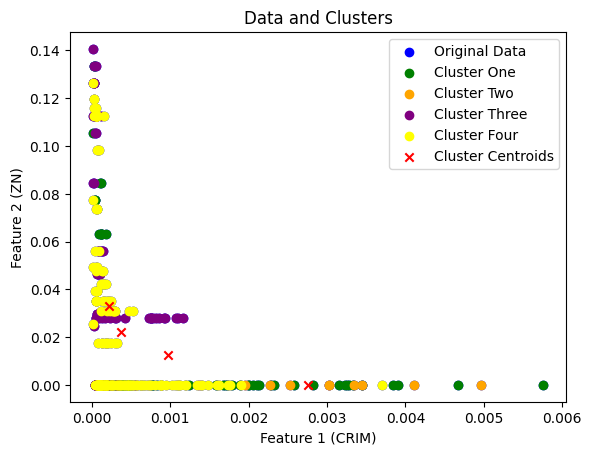

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

#load data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

#scale data
def minmax_scaler(x):
    scaled_point = ((x - np.min(x))/(np.max(x) - np.min(x))) #(x - min)/(max - min)
    return scaled_point

data = minmax_scaler(data)

#remove outliers using z-score
def remove_outliers(df, threshold=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < threshold).all(axis=1)]

#kept about 73% of the original data points
data = remove_outliers(data)

#pick four random indexes for centroids
cluster_centroids = data[np.random.choice(len(data), 4, replace=False)]

#create arrays to represent each cluster
cluster_one = []
cluster_two = []
cluster_three = []
cluster_four = []

#calculate distances and assign to clusters
def cluster_points(point):
    distances = []
    for centroid in cluster_centroids:
        temp_distance = np.sqrt(np.sum(np.subtract(centroid, point) ** 2))  # Euclidean distance
        distances.append(temp_distance)

    #find index of lowest distance
    min_distance_index = np.argmin(distances)

    #add each point to closest cluster
    if min_distance_index == 0:
        cluster_one.append(point)
    elif min_distance_index == 1:
        cluster_two.append(point)
    elif min_distance_index == 2:
        cluster_three.append(point)
    else:
        cluster_four.append(point)

#assign each data point to closest centroid
for point in data:
    cluster_points(point)

#update centroids function
def update_centroids(cluster):
    new_centroid = np.mean(cluster, axis=0)
    return new_centroid

#compute SSE
def SSE(cluster_centroids, clusters):
    sse = 0
    for i in range(len(clusters)):
        sse += np.sum((clusters[i] - cluster_centroids[i])**2)
    return sse

#initialize iteration counter and error
iteration = 1
error = float('inf')

#iterate until convergence
while True:

    #update centroids
    new_cluster_centroids = [update_centroids(cluster) for cluster in [cluster_one, cluster_two, cluster_three, cluster_four]]

    #reassign points to clusters using new centroids
    cluster_one = []
    cluster_two = []
    cluster_three = []
    cluster_four = []
    for point in data:
        cluster_points(point)

    #recompute SSE
    new_error = SSE(new_cluster_centroids, [cluster_one, cluster_two, cluster_three, cluster_four])

    #check for convergence
    if new_error == error: #end while loop if there is no change in error
        break
    else:
        error = new_error #update error
        cluster_centroids = new_cluster_centroids #update centroids again

    print(f"Iteration {iteration}: SSE = {error}")
    iteration += 1 #iterate

#initialize scatter plot
plt.scatter(data[:, 0], data[:, 1], c='blue', label='Original Data')

#plot points in each cluster
plt.scatter(np.array(cluster_one)[:, 0], np.array(cluster_one)[:, 1], c='green', label='Cluster One')
plt.scatter(np.array(cluster_two)[:, 0], np.array(cluster_two)[:, 1], c='orange', label='Cluster Two')
plt.scatter(np.array(cluster_three)[:, 0], np.array(cluster_three)[:, 1], c='purple', label='Cluster Three')
plt.scatter(np.array(cluster_four)[:, 0], np.array(cluster_four)[:, 1], c='yellow', label='Cluster Four')

#plot cluster centroids
plt.scatter(np.array(cluster_centroids)[:, 0], np.array(cluster_centroids)[:, 1], c='red', label='Cluster Centroids', marker='x')

plt.xlabel('Feature 1 (CRIM)')
plt.ylabel('Feature 2 (ZN)')
plt.title('Data and Clusters')
plt.legend()
plt.show()

Decision Tree

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import some data
iris = datasets.load_iris()
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
#retrieve the data
X = iris.data
Y = iris.target.reshape(-1,1)

#split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 60)

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):

        #initialize features for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        #initialize value of leaf node
        self.value = value

class DecisionTree():

  def __init__(self, min_samples_split=2, max_depth=2):
      #initialize root
      self.root = None
      #initialize terminating conditions
      self.min_samples_split = min_samples_split
      self.max_depth = max_depth

  def split(self, iris, feature_index, threshold):

    #split data left and right
    iris_left = np.array([row for row in iris if row[feature_index]<=threshold])
    iris_right = np.array([row for row in iris if row[feature_index]>threshold])
    return iris_left, iris_right


  def get_best_split(self, iris, n_samples, n_features):

      #store best split
      best_split = {}
      max_info_gain = -float("inf") #places no limit on min value to maximize information gain

      #traverse through all features/values
      for feature_index in range(n_features):
        feature_values = iris[:, feature_index]
        possible_thresholds = np.unique(feature_values)

        #loop over all features/values currently encountered in data
        for threshold in possible_thresholds:
          iris_left, iris_right = self.split(iris, feature_index, threshold) #retrieves current split

          #check if child nodes contain data
          if(len(iris_left)>0 and len(iris_right)>0):
            #extract targets
            y, left_y, right_y = iris[:,-1], iris_left[:,-1], iris_right[:,-1]
            #get current information gain
            current_info_gain = self.get_info_gain(y, left_y, right_y, "gini_index")

            #update best split
            if(current_info_gain > max_info_gain):
              best_split["feature_index"] = feature_index
              best_split["threshold"] = threshold
              best_split["iris_left"] = iris_left
              best_split["iris_right"] = iris_right
              best_split["info_gain"] = current_info_gain
              max_info_gain = current_info_gain

      return best_split

  def build_tree(self, iris, current_depth=0):
      #split features/targets, define shape
      X, Y = iris[:,:-1], iris[:,-1]
      n_samples, n_features = np.shape(X)

      #split until terminating conditions are met
      if n_samples>=self.min_samples_split and current_depth<=self.max_depth:
        best_split = self.get_best_split(iris, n_samples, n_features) #call best split method
        #check if info gain is positive or negative
        if(best_split["info_gain"] > 0):
          left_subtree = self.build_tree(best_split["iris_left"], current_depth+1) #recursively create left subtrees
          right_subtree = self.build_tree(best_split["iris_right"], current_depth+1) #recursively create right subtrees
          return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"])

      #calculate value of leaf node
      leaf_value = self.calculate_leaf_value(Y)
      #return node with new leaf value
      return Node(value = leaf_value)

  def get_info_gain(self, parent, left_child, right_child, mode = "entropy"):
    #initialize weights for each child node
    left_weight = len(left_child)/len(parent)
    right_weight = len(right_child)/len(parent)

    #calculate gain using gini index or entropy
    if(mode=="gini_index"):
      child_ginis = (left_weight*self.calculate_gini_index(left_child) + right_weight*self.calculate_gini_index(right_child)) #sum(weight*gini) for each child node
      gain = self.calculate_gini_index(parent) - child_ginis #subtract from parent's gini index to calculate gain
    else:
      child_entropy = left_weight*self.calculate_entropy(left_child) + right_weight*self.calculate_entropy(right_child) #sum(weight*entropy) for each child node
      gain = self.calculate_entropy(parent) - child_entropy #subtract from parent's entropy to calculate gain
    return gain

  def calculate_entropy(self, y):
    #initialize class labels and entropy
    class_labels = np.unique(y)
    entropy = 0

    for nth_label in class_labels:
      p_nth_label = len(y[y==nth_label])/len(y) #find probability of each flower type appearing in dataset
      entropy += -p_nth_label*np.log2(p_nth_label) #entropy = sum(-p/*logp)
    return entropy

  def calculate_gini_index(self, y): #gini index = 1 - sum(p^2)
    #initialize class labels and entropy
    class_labels = np.unique(y)
    entropy = 0

    for nth_label in class_labels:
      p_squared = 0
      p_nth_label = len(y[y==nth_label])/len(y) #find probability of each flower type appearing in dataset
      p_squared += (-p_nth_label)**2 #entropy = sum(-p/*logp)
      gini_index = 1 - p_squared
    return gini_index

  def calculate_leaf_value(self, Y):
    #compute leaf node
    Y = list(Y)
    return max(Y, key = Y.count) # finds majority class

  #print out tree for visualization (pre-order traversal)
  def print_tree(self, tree=None, indent = " "):

    if not tree:
      tree = self.root

    if tree.value is not None:
      print(tree.value)

    else:
      print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
      print("\n%sleft: " % (indent), end="")
      self.print_tree(tree.left, indent + indent)
      print("\n%sright: " % (indent), end="")
      self.print_tree(tree.right, indent + indent)

  def fit(self, X, Y):
    #concatenate data for training
    iris = np.concatenate((X, Y), axis=1)
    #call build tree function
    self.root = self.build_tree(iris)

  def calculate_prediction(self, x, tree):

    #check if node is a leaf node
    if tree.value != None:
      return tree.value #if leaf node
    #if not a leaf, extract feature from datapoint at feature index
    feature_value = x[tree.feature_index] #test direction
    if feature_value <= tree.threshold:
      return self.calculate_prediction(x, tree.left)
    else:
      return self.calculate_prediction(x, tree.right)

  def predict(self, X):
    predictions = [self.calculate_prediction(x, self.root) for x in X]
    return predictions

#fit model
classifier = DecisionTree(min_samples_split = 3, max_depth = 3)
classifier.fit(X_train, Y_train)
classifier.print_tree()

#test model
Y_predicted = classifier.predict(X_test)
print("\nAccuracy: ", accuracy_score(Y_test, Y_predicted))

X_2 <= 1.9 ? 0.35062100393955054

 left: 0.0

 right: X_2 <= 4.7 ? 0.6109493322558397

  left: 1.0

  right: X_3 <= 1.6 ? 0.03843210979316841

    left: X_2 <= 4.9 ? 0.5663265306122449

        left: 1.0

        right: 2.0

    right: X_2 <= 4.8 ? 0.007889546351084811

        left: 2.0

        right: 2.0

Accuracy:  0.9473684210526315


Ensemble Classifier

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import numpy as np
data = load_breast_cancer()
list(data.target_names)
['malignant', 'benign']

X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

X_train_scaled = minmax_scaler(X_train)
X_test_scaled = minmax_scaler(X_test)
#scale data
def minmax_scaler(x):
    scaled_point = ((x - np.min(x))/(np.max(x) - np.min(x))) #(x - min)/(max - min)
    return scaled_point

X = minmax_scaler(X)
y = minmax_scaler(y)

class LogisticRegression:
  #constructor
  def __init__(self, learning_rate=0.05):
    self.learning_rate=learning_rate
    #initializing weights and bias
    self.weights = None
    self.bias=0

  #sigmoid function
  def sigmoid(self, z):
    return 1/(1+np.exp(np.clip(-z, -500, 500)))

  #fit method
  def fit(self, X, y):
    n_samples, n_features=X.shape

    #initialize weights with zeros
    if self.weights is None:
      self.weights=np.zeros(n_features, dtype=np.float128)

    #gradient descent
    linear_combination = np.dot(X, self.weights) + self.bias #y=wx+b
    y_predicted = self.sigmoid(linear_combination) #implements sigmoid function

    #gradient derivatives for weights and biases
    dw=(1/n_samples)*np.dot(X.T, (y_predicted -y))
    db=(1/n_samples)*np.sum(y_predicted-y)

    #update weights
    self.weights-=self.learning_rate*dw
    self.bias-=self.learning_rate*db

  #predict method
  def predict(self, X):
    linear_combination=np.dot(X, self.weights)+self.bias #y=wx+b
    y_predicted = self.sigmoid(linear_combination)

    #round predictions to zero or 1
    y_predicted_label=[]
    for i in range(len(y_predicted)):
      if y_predicted[i] >= 0.5:
        y_predicted_label.append(1)
      else:
        y_predicted_label.append(0)

    return y_predicted_label

#calculate accuracy
def accuracy(y_actual, y_predicted):
  accuracy=np.sum(y_actual==y_predicted)/ len(y_actual)
  return accuracy

acc=[]
itr=[]

regressor = LogisticRegression(learning_rate=0.05)

for i in range(10000):
  regressor.fit(X_train, y_train)
  itr.append(i)

  predictions=regressor.predict(X_test)
  acc.append(accuracy(y_test, predictions))

print("Logistic Regression Accuracy: ", acc[len(acc)-1])

class NeuralNetwork:
  #sigmoid activation function
  def sigmoid(self,z):
      return 1 / (1 + np.exp(-z))

  #derivative of sigmoid function
  def sigmoid_derivative(self,z):
      return self.sigmoid(z) * (1 - self.sigmoid(z))

  #define mse loss function
  def mse_loss(y_true, y_pred):
      return np.mean((y_true - y_pred)**2)

  #initialize weights and biases
  input_size = X_train_scaled.shape[1]
  hidden_size = 4
  output_size = 1

  np.random.seed(0)
  weights_input_hidden = np.random.randn(input_size, hidden_size)
  biases_input_hidden = np.zeros((1, hidden_size))
  weights_hidden_output = np.random.randn(hidden_size, output_size)
  biases_hidden_output = np.zeros((1, output_size))

  #initialize learning rate
  learning_rate = 0.01

  #train the neural network (fit method)
  def fit(self, X, y):
    num_epochs = 10000
    for epoch in range(num_epochs):
        #forward pass
        hidden_layer_input = np.dot(X_train_scaled, self.weights_input_hidden) + self.biases_input_hidden
        hidden_layer_output = self.sigmoid(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.biases_hidden_output
        output = self.sigmoid(output_layer_input)

        #backpropogation
        output_error = y_train.reshape(-1, 1) - output
        output_delta = output_error * self.sigmoid_derivative(output_layer_input)

        hidden_layer_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_layer_delta = hidden_layer_error * self.sigmoid_derivative(hidden_layer_input)

        #update weights and biases
        self.weights_hidden_output += self.learning_rate * np.dot(hidden_layer_output.T, output_delta)
        self.biases_hidden_output += self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        self.weights_input_hidden += self.learning_rate * np.dot(X_train_scaled.T, hidden_layer_delta)
        self.biases_input_hidden += self.learning_rate * np.sum(hidden_layer_delta, axis=0, keepdims=True)

  #predict method
  def predict(self, X):
    self.hidden_layer_input = np.dot(X_test_scaled, self.weights_input_hidden) + self.biases_input_hidden
    self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
    self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_hidden_output
    predicted_output = self.sigmoid(self.output_layer_input)

    #round predicted output to 0 or 1
    predicted_classes = np.round(predicted_output).flatten()
    return predicted_classes

    #calculate accuracy

    accuracy = np.mean(predicted_classes == y_test)
    print("Neural Network Accuracy:", accuracy)


#initialize euclidean distance
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum(x1 - x2)**2)

class KNearestNeighbors:
  def __init__(self, k=4):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def find_most_common(self, x):
    distances = [euclidean_distance(x, x_train) for x_train in self.X_train] #euclidean distance
    k_indices = np.argsort(distances[:self.k]) #sorts indices by distance
    k_nearest_labels = [self.y_train[i] for i in k_indices] #assigns labels
    most_common = np.argmax(np.bincount(k_nearest_labels)) #identifies most common label
    return most_common

  #predict method
  def predict(self, X):
    #create array of predictions
    predictions = [self.find_most_common(x) for x in X]
    return np.array(predictions)

  #calculate accuracy
  accuracy = np.mean(predictions == y_test)
  print("KNN Accuracy:", accuracy)

class EnsembleClassifier:
  def __init__(self):
    #initialize abbreviations for each class
    self.lr = LogisticRegression()
    self.nn = NeuralNetwork()
    self.knn = KNearestNeighbors()

  def fit(self, X, y):
    #call fit methods from each class
    self.lr.fit(X, y)
    self.nn.fit(X, y)
    self.knn.fit(X, y)

  def predict(self, X):
    lr_predictions = self.lr.predict(X)
    nn_predictions = self.nn.predict(X)
    knn_predictions = self.knn.predict(X)

    #handle cases where any of the predictions are None
    if lr_predictions is None or nn_predictions is None or knn_predictions is None:
        return None

    #voting mechanism
    ensemble_predictions = np.array([np.mean([lr_pred, nn_pred, knn_pred]) >= 0.5 for lr_pred, nn_pred, knn_pred in zip(lr_predictions, nn_predictions, knn_predictions)], dtype=int)

    return ensemble_predictions

ec = EnsembleClassifier()
ec.fit(X_train_scaled, y_train)
ec_predictions = ec.predict(X_test_scaled)
#calculate accuracy
accuracy = np.mean(ec_predictions == y_test)
print("Ensemble Classifier Accuracy:", accuracy)


Logistic Regression Accuracy:  0.8771929824561403
KNN Accuracy: 0.8771929824561403
Ensemble Classifier Accuracy: 0.6608187134502924
